In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

import matplotlib.pyplot as plt
%matplotlib inline

/home/koosterb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/koosterb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/koosterb/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/koosterb/miniconda3/lib/python3.7/site-packages/tensorflow/python/f

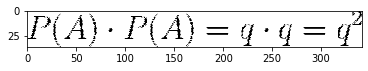

In [2]:
image_path = list(Path('/data/images/').rglob('*.png'))[100]
img = PIL.Image.open(image_path)
data = np.asarray(img)
plt.imshow(data, cmap='Greys')

In [3]:
image_dirname = Path('/data/images/')
data_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.1,
)

In [4]:
dgen_args = {
    'directory': image_dirname,
    'target_size': (64, 128),
    'class_mode': 'sparse',
    'batch_size': 512,
    'shuffle': True,
    'color_mode': 'rgb'
}

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

n_batches = len(train_dg)
trainX = []
for i in range(100):
    batch = train_dg.next()
    trainX.append(batch[0])
trainX = np.concatenate(trainX, axis=0)
data_generator.fit(trainX)

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.


/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/koosterb/miniconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.


batch mean: 375.7159
batch std: 167.9365
batch shape: (512, 64, 128, 3)
Standard Normal: False


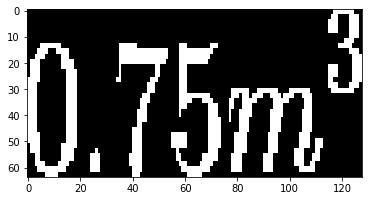

In [31]:
batch = train_dg.next()
X = batch[0]
print(f'batch mean: {X.mean():0.4f}')
print(f'batch std: {X.std():0.4f}')
print(f'batch shape: {X.shape}')
m, s = X.mean(), X.std()
print(f'Standard Normal: {(np.isclose(m,0, atol=0.1)) and (np.isclose(s, 1, atol=0.1))}')
plt.imshow(X[0, ..., 0], cmap='Greys')
plt.show()

In [75]:
from keras.applications.resnet50 import ResNet50
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras import layers

In [32]:
resnet = ResNet50(input_shape=(64,128,3), include_top=False, weights='imagenet')

In [33]:
print(resnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 134, 3)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [34]:
num_classes = 3

# Freeze the layers 
for layer in resnet.layers:
    layer.trainable = False
    
x = Flatten()(resnet.output)
x = Dense(num_classes, activation = 'softmax')(x)
resnet_model = Model(inputs = resnet.input, outputs = x)

In [35]:
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [36]:
resnet_model = compile_model(resnet_model)
print(resnet_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 134, 3)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [37]:
history = resnet_model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=10,
    shuffle=True
)

Epoch 1/10


/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


990/990 [==============================] - 664s 671ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.8831 - val_loss: 1.4451 - val_sparse_categorical_accuracy: 0.9049
Epoch 2/10
990/990 [==============================] - 650s 657ms/step - loss: 0.4546 - sparse_categorical_accuracy: 0.8838 - val_loss: 1.3017 - val_sparse_categorical_accuracy: 0.9049
Epoch 3/10
990/990 [==============================] - 649s 655ms/step - loss: 0.4461 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.9090 - val_sparse_categorical_accuracy: 0.9049
Epoch 4/10
990/990 [==============================] - 651s 657ms/step - loss: 0.4449 - sparse_categorical_accuracy: 0.8843 - val_loss: 1.1047 - val_sparse_categorical_accuracy: 0.9049
Epoch 5/10
990/990 [==============================] - 652s 659ms/step - loss: 0.4438 - sparse_categorical_accuracy: 0.8838 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.9049
Epoch 6/10
990/990 [==============================] - 650s 657ms/step - loss: 0.4458 - spar

In [38]:
from matplotlib import pyplot as plt

def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
    # save plot to file
    filename = "cv_first_try"
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()

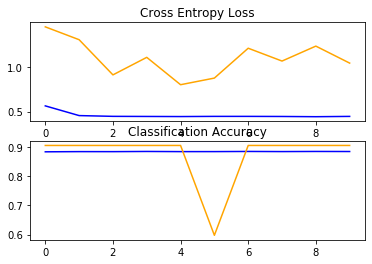

In [39]:
summarize_diagnostics(history)

In [76]:
def pretrained_model():
    pretrained_model = applications.VGG16(input_shape=(64, 128, 3), include_top=False, weights='imagenet')
    pretrained_output = pretrained_model.get_layer('block2_pool').output  # intercept the intermediate layer output
    tmp = pretrained_output
    for i in range(5):  # stack convs on top of the pretrained
        conv1 = layers.Conv2D(64, 3, padding='same')(tmp)
        norm1 = layers.BatchNormalization()(conv1)
        act1 = layers.Activation('relu')(norm1)
        pool = layers.MaxPooling2D(3, padding='same')(act1)
        tmp = pool

    flat = layers.Flatten()(tmp)
    for i in range(5):  # stack dense layers on top of it
        flat = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(flat)
    output = layers.Dense(3, activation='softmax')(flat)
    
    for layer in pretrained_model.layers:  # freeze layers
        layer.trainable = False
    model = models.Model(pretrained_model.input, output)
    return model

In [78]:
from keras import applications

vgg = pretrained_model()
vgg = model_compile(vgg)

AttributeError: 'tuple' object has no attribute 'layer'

In [66]:
resnet = ResNet50(input_shape=(64,128,3), include_top=False, weights='imagenet')

In [70]:
for i in range(len(resnet.layers)-11):
    resnet.layers.pop()
print(resnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 134, 3)   0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [72]:
def do_model():
    pt_output = resnet.layers[10].output
    tmp = pt_output
        for i in range(5):  # stack convs on top of the pretrained
            conv1 = layers.Conv2D(64, 3, padding='same')(tmp)
            norm1 = layers.BatchNormalization()(conv1)
            act1 = layers.Activation('relu')(norm1)
            pool = layers.MaxPooling2D(3, padding='same')(act1)
            tmp = pool

        flat = layers.Flatten()(tmp)
        for i in range(5):  # stack dense layers on top of it
            flat = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(flat)
        output = layers.Dense(3, activation='softmax')(flat)

        for layer in pretrained_model.layers:  # freeze layers
            layer.trainable = False
        model = models.Model(pretrained_model.input, output)
        

AttributeError: 'InputLayer' object has no attribute 'layers'